In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel('House_data.xlsx')#index_col
df.head(1)

,ID,Noi_dung,Dia_chi,Gia,Nha_ve_sinh,So_phong,Huong,Chieu_dai,Rong,Giay_to,Cau_truc,Dien_tich,Dien_tich_su_dung,Hem_rong,Duong_mat_tien,Tien_ich,Duong,Phuong,Quan
0,149065,Bán nhà 134.7m2 Tân Hiệp Hóc Môn. Cách Đỗ Văn ...,"Đường ấp Thới Tây 2, Xã Tân Hiệp, Huyện Hóc Môn","3,7 tỷ 35,4 triệu/m²",4,3,Đ.Bắc,20.71,5.0,Sổ hồng,1 trệt + 1 lầu,104.5,134.7,5.0,0.0,"Gần chợ, siêu thị Gần bệnh viện Gần công viên,...",Đường ấp Thới Tây 2,Xã Tân Hiệp,Huyện Hóc Môn


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4386 entries, 0 to 4385
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 4386 non-null   int64  
 1   Noi_dung           4386 non-null   object 
 2   Dia_chi            4386 non-null   object 
 3   Gia                4386 non-null   object 
 4   Nha_ve_sinh        4386 non-null   object 
 5   So_phong           4386 non-null   object 
 6   Huong              4386 non-null   object 
 7   Chieu_dai          4386 non-null   float64
 8   Rong               4386 non-null   float64
 9   Giay_to            4386 non-null   object 
 10  Cau_truc           4386 non-null   object 
 11  Dien_tich          4386 non-null   object 
 12  Dien_tich_su_dung  4386 non-null   object 
 13  Hem_rong           4386 non-null   float64
 14  Duong_mat_tien     4386 non-null   float64
 15  Tien_ich           3551 non-null   object 
 16  Duong              4386 

In [4]:
df.drop(columns=['Noi_dung','Dia_chi','ID'],inplace=True)

### 1.Xử Lý null và giá trị không hợp lệ của các biến continuous


In [5]:
for i in ['Dien_tich','Dien_tich_su_dung']:
    lst=df[i][df[i].str.contains('\d+\.\d{3}\.')==True].str.split('\.',expand=True).astype(str)####
    lst['ghep']=(lst[0]+lst[1]+'.'+lst[2]).astype(float)
    df[i][df[i].str.contains('\d+\.\d{3}\.')==True]=lst['ghep']
    print(df[i][df[i].str.contains('\d+\.\d{3}\.')==True])
df[['Dien_tich','Dien_tich_su_dung']]=df[['Dien_tich','Dien_tich_su_dung']].astype(float)

Series([], Name: Dien_tich, dtype: object)
Series([], Name: Dien_tich_su_dung, dtype: object)


In [6]:
df['Gia_ty']=df['Gia'].str.extract('(.+) tỷ \d+')
df['Gia_trieu_đong']=df['Gia_ty'].str.replace(',','.').astype(float)*1000### chuyển tỷ sang triẹu
df['Gia']=df['Gia'].str.replace(',','.')
df['Don_gia_trieu']=df['Gia'].str.extract('[Đã bán|triệu] (\d+\.?\d+) triệu/m²').astype(float)
df.loc[1152,'Don_gia_trieu']=1100### TH ngoại lệ 1,1 tỷ/mét vuông
ind_gia=df.Gia_trieu_đong[df.Gia_trieu_đong.isnull()==True].index
df.loc[ind_gia,'Gia_trieu_đong']=df.loc[ind_gia,'Don_gia_trieu']*df.loc[ind_gia,'Dien_tich']
df = df.dropna(axis=0, subset=['Gia_trieu_đong'])

In [7]:
print(df.Duong.unique())# nên bỏ feature này
len(df.Duong.unique())

['Đường ấp Thới Tây 2' 'Đường Hậu Giang' 'Đường Nguyễn Thượng Hiền' ...
 'Đường Dân Thắng 1' 'Đường ấp 3' 'Đường TRẦN VĂN GIÀU']


1044

In [8]:
df.drop(['Duong','Gia'],axis=1,inplace=True)

In [9]:
df.Cau_truc

0                                  1 trệt + 1 lầu
1                                          1 trệt
2                                1 trệt, 1 lửng  
3                                1 trệt + 1 lầu  
4         1 trệt, 1 lửng, 1 tầng thượng + 2 lầu  
                          ...                    
4381                             1 trệt + 1 lầu  
4382                             1 trệt + 2 lầu  
4383              1 trệt, 1 tầng thượng + 2 lầu  
4384                               1 trệt + 1 lầu
4385                   1 trệt, 1 lửng, 1 áp mái  
Name: Cau_truc, Length: 4385, dtype: object

In [10]:
df['C2']=df['Cau_truc'].str.extract('(\d+) lầu')
df['C2'].fillna(0.1,inplace=True)
df['C2']=df['C2'].astype(int)

In [11]:
# Xử lý ván đề Hem_rong=0 tức là có mặt đường: tăng hệ só cho biến mặt đường roi thay  thế các giá trị mặt đường =0 bằng biến hẻm rộng
df['Duong_mat_tien']=df['Duong_mat_tien']*1.3
ind=df[df['Duong_mat_tien']==0].index
df.loc[ind,'Duong_mat_tien']=df.loc[ind,'Hem_rong']
df.drop(['Hem_rong'],axis=1,inplace=True)

In [12]:
df.So_phong.unique()####

array([3, '--', '  --  ', 2, 5, 4, 15, 6, 8, 11, 12, 1, 9, 13, 32, 20, 16,
       7, 10, 25, 14, 42, 44, 19, 28, 18, 26, 24, 17, 23, 40, 21, 30, 73,
       45, 84, 38, 22, 60, 29], dtype=object)

In [13]:
df.Nha_ve_sinh.unique()####

array([4, 1, 2, 5, 3, 15, 6, 11, 12, 9, 7, 13, 32, 20, 10, 8, 25, '--',
       14, 42, 16, 44, 17, 19, 28, '  --  ', 18, 27, 29, 24, 23, 40, 21,
       30, 33, 73, 45, 85, 38, 26, 22, 60, 36], dtype=object)

In [14]:
df['So_phong'][df['So_phong'] =='  --  ']=np.nan
df['So_phong'][df['So_phong'] =='--']=np.nan
df['Nha_ve_sinh'][df['Nha_ve_sinh'] =='--']=np.nan
df['Nha_ve_sinh'][df['Nha_ve_sinh'] =='  --  ']=np.nan
df[['So_phong','Nha_ve_sinh']]=df[['So_phong','Nha_ve_sinh']].astype(float)
df['So_phong'].fillna(round(df['So_phong'][df['So_phong'].notnull()].median(),0),inplace=True)#### vòng lặp ko thể thay đổi
df['Nha_ve_sinh'].fillna(round(df['Nha_ve_sinh'][df['Nha_ve_sinh'].notnull()].median(),0),inplace=True)

In [15]:
df.Huong.unique()

array(['Đ.Bắc', 'Tây', 'T.Nam', 'Bắc', 'Đ.Nam', 'T.Bắc', 'Đông', 'Nam',
       'Không xác định'], dtype=object)

In [16]:
df.Giay_to.unique()

array(['Sổ hồng', 'Sổ đỏ', 'Giấy chứng nhận phường quận', 'Khác'],
      dtype=object)

In [17]:
df['Giayto']=df['Giay_to'].apply(lambda x:0 if x=='Sổ hồng' else 1 if x=='Sổ đỏ' else 2 if x=='Giấy chứng nhận phường quận' else 3)

In [18]:
df[['Giay_to','Quan','Huong']]=df[['Giay_to','Quan','Huong']].astype('category')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4385 entries, 0 to 4385
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Nha_ve_sinh        4385 non-null   float64 
 1   So_phong           4385 non-null   float64 
 2   Huong              4385 non-null   category
 3   Chieu_dai          4385 non-null   float64 
 4   Rong               4385 non-null   float64 
 5   Giay_to            4385 non-null   category
 6   Cau_truc           4385 non-null   object  
 7   Dien_tich          4385 non-null   float64 
 8   Dien_tich_su_dung  4385 non-null   float64 
 9   Duong_mat_tien     4385 non-null   float64 
 10  Tien_ich           3550 non-null   object  
 11  Phuong             4385 non-null   object  
 12  Quan               4385 non-null   category
 13  Gia_ty             4301 non-null   object  
 14  Gia_trieu_đong     4385 non-null   float64 
 15  Don_gia_trieu      85 non-null     float64 
 16  C2    

In [20]:
print(df.Quan.unique())
len(df.Quan.unique())

[' Huyện Hóc Môn', ' Quận 6', ' Quận Gò Vấp', ' Huyện Nhà Bè', ' Quận 11', ..., ' Quận 12', ' Quận 5', ' Quận Tân Phú', ' Huyện Bình Chánh', ' Quận 4']
Length: 22
Categories (22, object): [' Huyện Hóc Môn', ' Quận 6', ' Quận Gò Vấp', ' Huyện Nhà Bè', ..., ' Quận 5', ' Quận Tân Phú', ' Huyện Bình Chánh', ' Quận 4']


22

In [21]:
df.Tien_ich.head()


0    Gần chợ, siêu thị Gần bệnh viện Gần công viên,...
1    Gần chợ, siêu thị Gần công viên, trung tâm Di ...
2     Gần chợ, siêu thị Gần công viên, trung tâm Gầ...
3     Gần chợ, siêu thị Gần bệnh viện Gần công viên...
4                                                  NaN
Name: Tien_ich, dtype: object

In [22]:
# Gần chợ, siêu thị
# Gần bệnh viện
# Gần công viên, trung tâm
# Gần trường học
# Di chuyển thuận tiện ra trung tâm
# Sân để xe rộng rãi
# Thiết kế thông thoáng
# Cần bán gấp
# Gần mặt tiền đường
# Hẻm thông
# 2 Mặt đường chính
# Khu vực an ninh
# Nở hậu
# 2 Mặt hẻm

In [23]:
df[['chợ','bv','cv','tt','th','sân','thietke','đg','gấp','hẻm','đgchinh','anninh','nohau','mathem']]=0
df.loc[(df['Tien_ich'].str.contains('Gần chợ, siêu thị'))==True,'chợ']=1
df.loc[(df['Tien_ich'].str.contains('Gần bệnh viện'))==True,'bv']=1
df.loc[(df['Tien_ich'].str.contains('Gần công viên, trung tâm'))==True,'cv']=1
df.loc[(df['Tien_ich'].str.contains('Gần trường học'))==True,'th']=1
df.loc[(df['Tien_ich'].str.contains('Di chuyển thuận tiện ra trung tâm'))==True,'tt']=1
df.loc[(df['Tien_ich'].str.contains('Sân để xe rộng rãi'))==True,'sân']=1
df.loc[(df['Tien_ich'].str.contains('Thiết kế thông thoáng'))==True,'thietke']=1
df.loc[(df['Tien_ich'].str.contains('Gần mặt tiền đường'))==True,'đg']=1
df.loc[(df['Tien_ich'].str.contains('Cần bán gấp'))==True,'gấp']=1
df.loc[(df['Tien_ich'].str.contains('Hẻm thông'))==True,'hẻm']=1
df.loc[(df['Tien_ich'].str.contains('2 Mặt đường chính'))==True,'đgchinh']=1
df.loc[(df['Tien_ich'].str.contains('Khu vực an ninh'))==True,'anninh']=1
df.loc[(df['Tien_ich'].str.contains('Nở hậu'))==True,'nohau']=1
df.loc[(df['Tien_ich'].str.contains('2 Mặt hẻm'))==True,'mathem']=1
df['Tien_ich']=df[['chợ','bv','cv','tt','th','sân','thietke','đg','gấp','hẻm','đgchinh','anninh','nohau','mathem']].sum(axis=1)
df.drop(['chợ','bv','cv','tt','th','sân','thietke','đg','gấp','hẻm','đgchinh','anninh','nohau','mathem'],axis=1,inplace=True)

In [24]:
df.corr()['Gia_trieu_đong']# giấy tờ, đg mặt tiền,C2,So_phong là có corr cao nhất  

Nha_ve_sinh          0.453902
So_phong             0.453289
Chieu_dai            0.501745
Rong                 0.409066
Dien_tich            0.563518
Dien_tich_su_dung    0.544333
Duong_mat_tien       0.360414
Tien_ich             0.013817
Gia_trieu_đong       1.000000
Don_gia_trieu        0.857176
C2                   0.327730
Giayto               0.008043
Name: Gia_trieu_đong, dtype: float64

In [25]:
import statsmodels.api as sm### lẽ ra phải làm cái này trc khi preprocess
from statsmodels.formula.api import ols
import scipy.stats       as stats
bieuthuc = 'Gia_trieu_đong ~ C(Huong) + C(Giay_to) + C(Quan)'
model = ols(bieuthuc, data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Huong),3.634469e+08,8.0,0.767169,6.318606e-01
C(Giay_to),4.456605e+08,3.0,2.508550,5.704640e-02
C(Quan),2.842792e+10,21.0,22.859449,1.866953e-83
Residual,2.577205e+11,4352.0,NaN,NaN


### Nhận xét: lấy độ tin cậy là 0.95 thì trong các biến category, sự khác biệt của biến Quan có ý nghĩa thống kê với biến Giá=> tạo dummy cho biến Quan

In [26]:
df_new = pd.get_dummies(data = df, columns=['Quan'], prefix='Dum')###

In [27]:
df_new.corr()['Gia_trieu_đong'].sort_values()

Dum_ Quận 8             -0.137362
Dum_ Huyện Nhà Bè       -0.100094
Dum_ Quận 12            -0.089488
Dum_ Quận Gò Vấp        -0.069461
Dum_ Quận Bình Tân      -0.060363
Dum_ Huyện Hóc Môn      -0.058408
Dum_ Quận 4             -0.049160
Dum_ Huyện Bình Chánh   -0.022890
Dum_ Quận Tân Phú       -0.004658
Dum_ Quận Thủ Đức        0.001443
Giayto                   0.008043
Dum_ Quận 9              0.008825
Dum_ Quận Bình Thạnh     0.010477
Dum_ Quận 7              0.012318
Tien_ich                 0.013817
Dum_ Quận 11             0.029713
Dum_ Quận Tân Bình       0.041385
Dum_ Quận 5              0.045165
Dum_ Quận Phú Nhuận      0.062104
Dum_ Quận 6              0.066425
Dum_ Quận 2              0.090395
Dum_ Quận 10             0.090999
Dum_ Quận 1              0.099200
Dum_ Quận 3              0.115087
C2                       0.327730
Duong_mat_tien           0.360414
Rong                     0.409066
So_phong                 0.453289
Nha_ve_sinh              0.453902
Chieu_dai     

## Kết hợp Visualize phân tích đơn biến và đa biến
## Xem đơn biến:

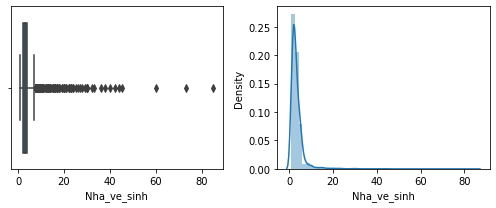

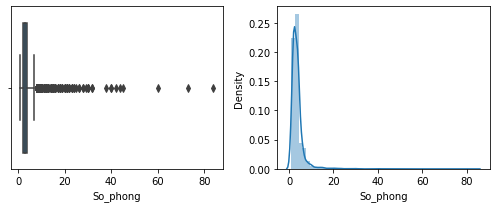

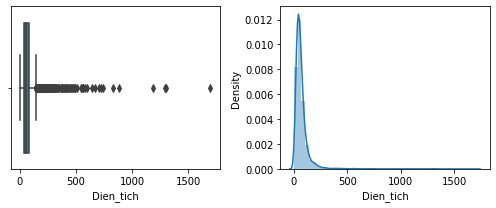

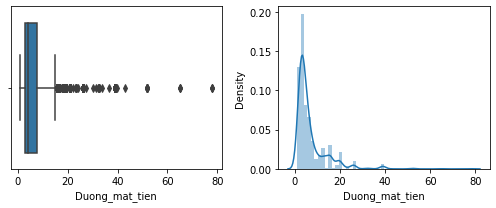

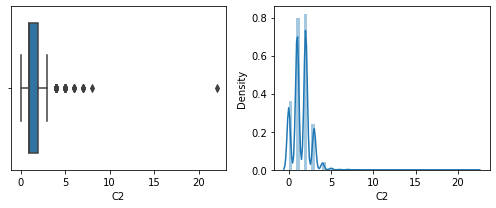

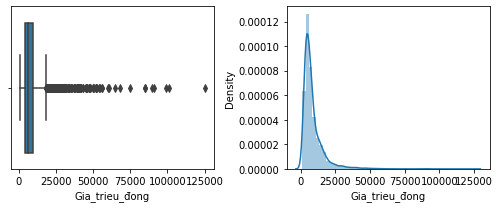

In [28]:
features=['Nha_ve_sinh','So_phong','Dien_tich','Duong_mat_tien','C2','Gia_trieu_đong']
for i in features:
    plt.figure(figsize=(7,3))
    plt.subplot(1,2,1)
    sns.boxplot(df[i])
    plt.subplot(1,2,2)
    sns.distplot(df[i])
    plt.tight_layout()
    plt.show()

## Nhận xét: tất cả các biến định lượng, kể cả biến phụ thuộc đều ko phấn phối chuẩn và có rất nhiều outliers

## Xem đa biến:

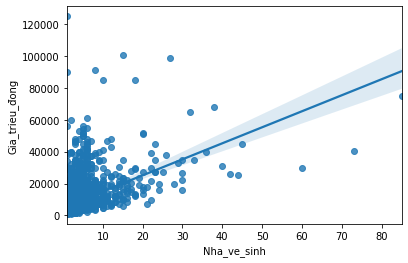

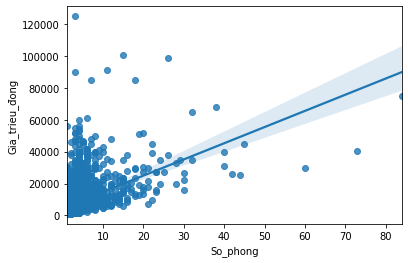

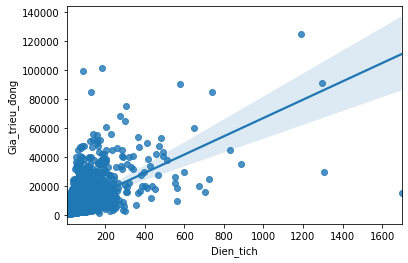

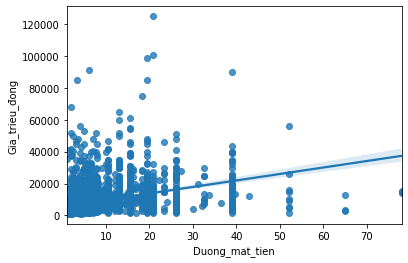

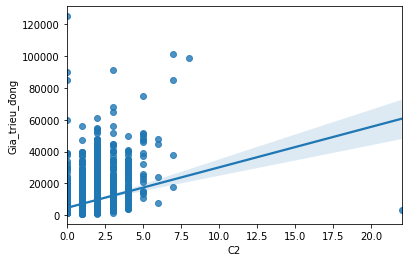

In [29]:
for i in features[0:-1]:
    sns.regplot(df[i],df['Gia_trieu_đong'])
    plt.show()

In [30]:
X = df_new[['So_phong', 'Dien_tich', 'Duong_mat_tien','C2','Dum_ Huyện Bình Chánh', 'Dum_ Huyện Hóc Môn', 'Dum_ Huyện Nhà Bè',
       'Dum_ Quận 1', 'Dum_ Quận 10', 'Dum_ Quận 11', 'Dum_ Quận 12',
       'Dum_ Quận 2', 'Dum_ Quận 3', 'Dum_ Quận 4', 'Dum_ Quận 5',
       'Dum_ Quận 6', 'Dum_ Quận 7', 'Dum_ Quận 8',
       'Dum_ Quận Bình Thạnh', 'Dum_ Quận Bình Tân', 'Dum_ Quận Gò Vấp',
       'Dum_ Quận Phú Nhuận', 'Dum_ Quận Tân Bình']] # bỏ 'Dum_ Quận Tân Phú', 'Dum_ Quận Thủ Đức', 'Dum_ Quận 9' vì corr chưa lên được 0.01
y = df['Gia_trieu_đong']

In [31]:
from sklearn.model_selection import train_test_split   
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [32]:
my_steps = [('scale', RobustScaler()),
            ('polynomial', PolynomialFeatures(degree=2)),
           ('model', LinearRegression())]
pipe = Pipeline(my_steps)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2,random_state=0)
id_lux=y_train[y_train>60000].index
X_train.drop(index=id_lux,axis=0,inplace=True)
y_train.drop(index=id_lux,axis=0,inplace=True)

id_phong=X_train[X_train.So_phong>40].index
X_train.drop(index=id_phong,axis=0,inplace=True)
y_train.drop(index=id_phong,axis=0,inplace=True)

id_s=X_train[X_train.Dien_tich>400].index
X_train.drop(index=id_s,axis=0,inplace=True)
y_train.drop(index=id_s,axis=0,inplace=True)

id_t=X_train[X_train.C2>5].index
X_train.drop(index=id_t,axis=0,inplace=True)
y_train.drop(index=id_t,axis=0,inplace=True)

id_mt=X_train[X_train.Duong_mat_tien>25].index
X_train.drop(index=id_mt,axis=0,inplace=True)
y_train.drop(index=id_mt,axis=0,inplace=True)

pipe.fit(X_train, y_train)
yhat_train = pipe.predict(X_train)
yhat_test = pipe.predict(X_test)
print('The train R-squared:', pipe.score(X_train, y_train))
print('The test R-squared:', pipe.score(X_test, y_test))
a=np.sqrt(((yhat_train - y_train) ** 2).mean())
b=np.sqrt(((yhat_test - y_test) ** 2).mean())
print('RMSE trên train và test lần lượt là: ',a,b)

The train R-squared: 0.7916004312683153
The test R-squared: 0.7857605820163363
RMSE trên train và test lần lượt là:  2895.834090297863 3477.785878419632


In [33]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
import datetime
from sklearn.neighbors import KNeighborsRegressor

### Thử thêm các loại model khác xem có cải thiện lên ko

In [34]:
models = [DecisionTreeRegressor(),
    RandomForestRegressor(),
    KNeighborsRegressor(),
    xgb.XGBRegressor(random_state=0),
    SVR(kernel='rbf')
]
CV = 10
entries = []
for model in models:
    time_scores=[]
    scores_train = []
    scores_test = []
    rmse_train=[]
    rmse_test=[]
    for j in range(CV):
        t1=datetime.datetime.now()
        model.fit(X_train,y_train)
        t2=datetime.datetime.now()
        model_name = model.__class__.__name__      
        time_scores.append(round((t2-t1).microseconds/1000,1)) 
        s_train = model.score(X_train,y_train)
        s_test =  model.score(X_test,y_test)
        scores_train.append(s_train)
        scores_test.append(s_test)          
        y_pred = model.predict(X_train)
        a=np.sqrt(((y_pred - y_train) ** 2).mean())
        rmse_train.append(a)
        y_predtest = model.predict(X_test)
        b=np.sqrt(((y_predtest - y_test) ** 2).mean())
        rmse_test.append(b)
    entries.append([model_name,np.array(time_scores).mean(),np.array(rmse_train).mean(),np.array(rmse_test).mean(),np.array(scores_train).mean(),np.array(scores_test).mean()])

cv_df = pd.DataFrame(entries, columns=['model_name','time_mean','rmse_train','rmse_test','scores_train','scores_test'])


In [35]:
cv_df

,model_name,time_mean,rmse_train,rmse_test,scores_train,scores_test
0,DecisionTreeRegressor,18.01,64.385131,5303.730084,0.999897,0.501517
1,RandomForestRegressor,287.08,1361.990495,4124.701640,0.953897,0.698619
2,KNeighborsRegressor,1.60,3946.450247,5844.481362,0.612954,0.394958
3,XGBRegressor,205.47,1129.522868,4222.082831,0.968294,0.684247
4,SVR,701.44,6500.610592,7723.449600,-0.050166,-0.056614


### Kết luận: dùng hồi quy tuyến tính là hiệu suất và rmse bé nhất

In [36]:
import pickle
def Save_object(obj,filename):
     #pkl_filename = "model_1.pkl"  
     with open(filename, 'wb') as file:  
          pickle.dump(obj, file)
     return
pipe.fit(X, y)
Save_object(pipe,'pipe.pkl')